Takwa Ben Radhia

# Subcellular localisation

Import des bibliothèques

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
import os
import requests
from tqdm import tqdm
import zipfile
from pandas import read_csv
from sklearn.model_selection import KFold
from tensorflow.keras.layers import BatchNormalization, Activation, Add, Input, AveragePooling1D
from tensorflow.keras.models import Model
import seaborn as sns
import sklearn


Import des données

In [ ]:
def download_data():
    datasetFolderPath = "dataset/"

    # Les fichiers à télécharger
    files = {
        "reduced_train.npz": "https://github.com/JJAlmagro/subcellular_localization/raw/refs/heads/master/notebook%20tutorial/data/reduced_train.npz",
        "reduced_val.npz": "https://github.com/JJAlmagro/subcellular_localization/raw/refs/heads/master/notebook%20tutorial/data/reduced_val.npz"
    }

    if not os.path.exists(datasetFolderPath):
        os.makedirs(datasetFolderPath)

    def download_file(url, filename):
        response = requests.get(url, stream=True)
        with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                           total=int(response.headers.get('content-length', 0)),
                           desc=filename) as fout:
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)

    # Téléchargement des fichiers s'ils n'existent pas déjà
    for file, url in files.items():
        file_path = os.path.join(datasetFolderPath, file)
        if not os.path.exists(file_path):
            download_file(url, file_path)

# Appel de la fonction
download_data()

Train data keys: ['X_train', 'y_train', 'mask_train']
Test data keys: ['X_val', 'y_val', 'mask_val']
X_train shape: (2423, 400, 20)
y_train shape: (2423,)
X_val shape: (635, 400, 20)
y_val shape: (635,)


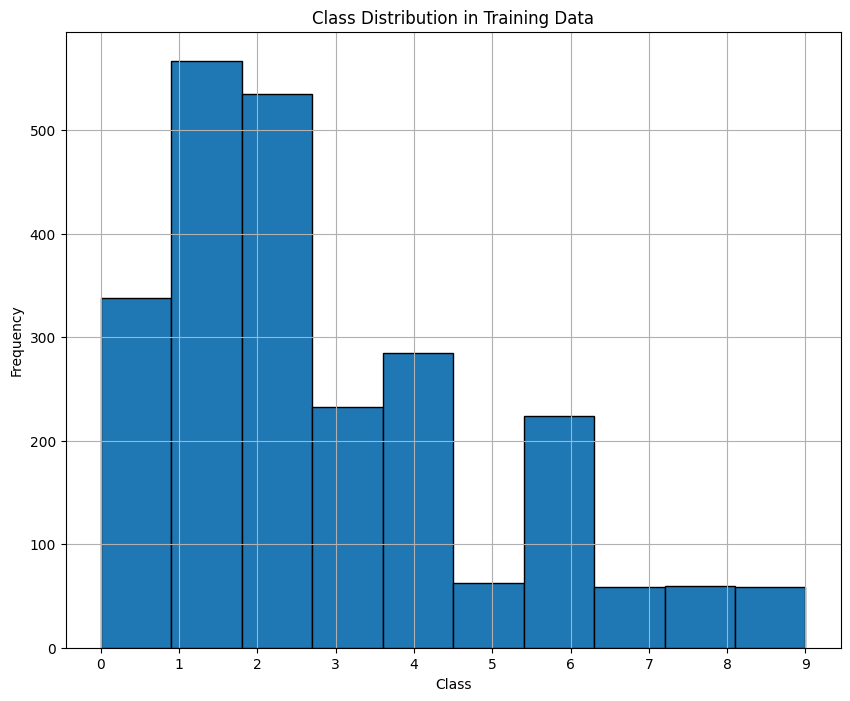

In [ ]:
train_data = np.load('dataset/reduced_train.npz')
test_data = np.load('dataset/reduced_val.npz')

# Print the keys
print('Train data keys:', train_data.files)
print('Test data keys:', test_data.files)

# Extract the data
X_train = train_data['X_train']
Y = train_data['y_train']
X_val = test_data['X_val']
y_val = test_data['y_val']

# Print the shapes
print('X_train shape:', X_train.shape)
print('y_train shape:', Y.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

# One-hot encode the labels
num_classes = 10
classes = preprocessing.LabelEncoder()
classes.fit(Y)
classes_Y = classes.transform(Y)
onehot_Y = to_categorical(classes_Y)
classes_y_val = classes.transform(y_val)
onehot_y_val = to_categorical(classes_y_val)

plt.figure(figsize=(10,8))
plt.hist(Y, bins=num_classes, edgecolor='black')
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, num_classes, 1))
plt.grid(True)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, onehot_Y, test_size=0.2, random_state=3, shuffle=True)

## Modèle CNN

In [ ]:
def model_cnn():
    model = Sequential()

    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_uniform', input_shape=(400, 20)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Aplatissement des résultats et couches denses
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    # Compilation du modèle
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
if len(y_train.shape) > 1 and y_train.shape[1] > 1:  # Si y_train est one-hot
    y_train2 = np.argmax(y_train, axis=1)
classes = np.unique(y_train2)  # Classes présentes dans les données
class_weights = compute_class_weight('balanced', classes=classes, y=y_train2)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
model_cnn = model_cnn()
history = model_cnn.fit(X_train, y_train, validation_split=0.2, epochs=25, batch_size=50)
#history = model_cnn.fit(X_train, y_train, validation_split=0.2, epochs=25, batch_size=50, class_weight=class_weight_dict)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.2491 - loss: 2.0691 - weighted_accuracy: 0.2491 - val_accuracy: 0.2861 - val_loss: 1.9047 - val_weighted_accuracy: 0.2861
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.3465 - loss: 1.7885 - weighted_accuracy: 0.3465 - val_accuracy: 0.5052 - val_loss: 1.5945 - val_weighted_accuracy: 0.5052
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5205 - loss: 1.4363 - weighted_accuracy: 0.5205 - val_accuracy: 0.6005 - val_loss: 1.2267 - val_weighted_accuracy: 0.6005
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.6614 - loss: 1.0509 - weighted_accuracy: 0.6614 - val_accuracy: 0.6727 - val_loss: 1.0019 - val_weighted_accuracy: 0.6727
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.7757 - loss: 0.7900 - weighted_accuracy: 0.7757 - val_accuracy: 0.7036 - val_loss: 0.8725 - val_weighted_accuracy: 0.7036
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.

In [ ]:
scores_train = model_cnn.evaluate(X_train, y_train)
scores = model_cnn.evaluate(X_test, y_test)
print("Neural network train accuracy: %.2f%%" % (scores_train[1]*100))
print("Neural network accuracy: %.2f%%" % (scores[1]*100))

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9923 - loss: 0.0535 - weighted_accuracy: 0.9923
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8204 - loss: 0.9165 - weighted_accuracy: 0.8204
Neural network train accuracy: 95.82%
Neural network accuracy: 81.65%


Il y a des classes sous représentées mais même lorsqu'on fait un weighted classes les performances restent les mêmes.

### Performances

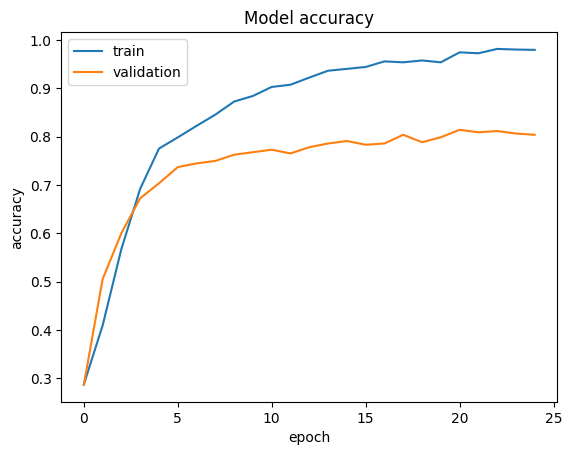

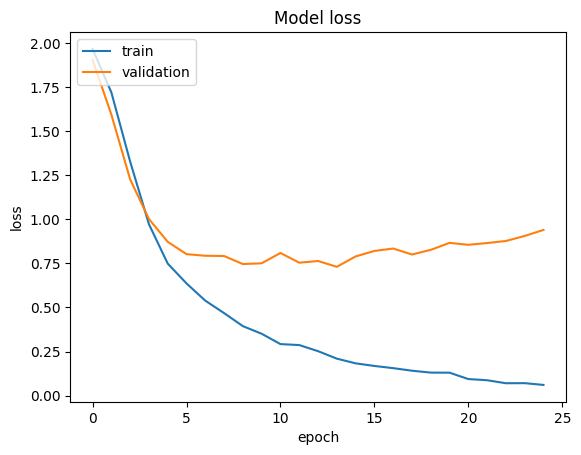

In [ ]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<Axes: >

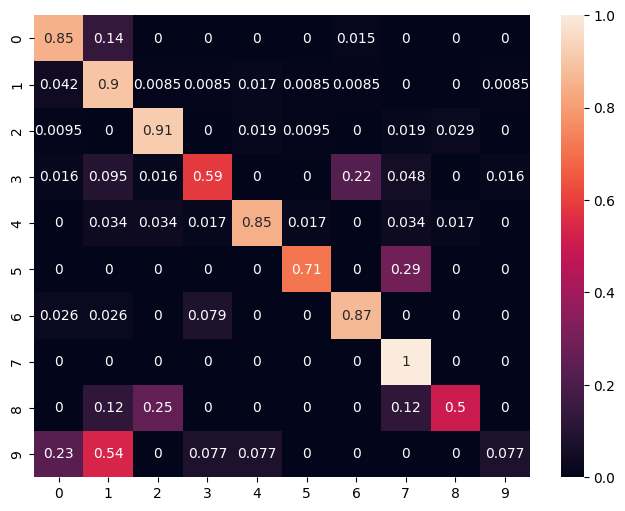

In [ ]:
y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1)

y_test_classes = np.argmax(y_test,axis = 1)
plt.figure(figsize=(8, 6))
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_pred_classes, normalize="true"), annot=True)

## K-fold

In [ ]:
def k_fold_cross_validation(X, y, k=5, epochs=10, batch_size=100):
    kfold = KFold(n_splits=k, shuffle=True, random_state=3)
    accuracy_per_fold = []
    fold_no = 1

    # Pour stocker les historiques de chaque pli
    all_acc = []
    all_val_acc = []
    all_loss = []
    all_val_loss = []

    for train_index, val_index in kfold.split(X):
        # Créer le modèle pour chaque pli
        model = model_cnn()

        print(f'Entraînement du fold {fold_no}...')

        # Séparer les données d'entraînement et de validation
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Entraînement du modèle sur les données d'entraînement du pli
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size)

        # Sauvegarder les historiques pour chaque pli
        all_acc.append(history.history['accuracy'])
        all_val_acc.append(history.history['val_accuracy'])
        all_loss.append(history.history['loss'])
        all_val_loss.append(history.history['val_loss'])

        # Évaluer le modèle sur les données de validation du pli
        scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        print(f'Fold {fold_no} - Accuracy: {scores[1]*100:.2f}%')
        accuracy_per_fold.append(scores[1] * 100)

        fold_no += 1

    # Résultats
    print('\nScores de chaque fold:', accuracy_per_fold)
    print(f'Moyenne de l\'accuracy: {np.mean(accuracy_per_fold):.2f}%')
    print(f'Variance de l\'accuracy: {np.std(accuracy_per_fold):.2f}%')

    # Tracer les courbes d'accuracy et de loss pour tous les plis sur un seul graphique
    plt.figure(figsize=(10, 6))

    # Tracer accuracy pour tous les plis
    for i in range(k):
        plt.plot(all_val_acc[i], label=f'Validation Accuracy Fold {i+1}')

    # Ajouter les titres et les légendes
    plt.title('Training and Validation Accuracy per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Afficher le graphique
    plt.show()

    # Tracer les courbes de loss pour tous les plis sur un seul graphique
    plt.figure(figsize=(10, 6))

    # Tracer loss pour tous les plis
    for i in range(k):
        plt.plot(all_val_loss[i], label=f'Validation Loss Fold {i+1}', linestyle='--', marker='x')

    # Ajouter les titres et les légendes
    plt.title('Training and Validation Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Afficher le graphique
    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Entraînement du fold 1...
Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.2718 - loss: 2.0629 - weighted_accuracy: 0.2718 - val_accuracy: 0.3170 - val_loss: 1.8512 - val_weighted_accuracy: 0.3170
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.3801 - loss: 1.7400 - weighted_accuracy: 0.3801 - val_accuracy: 0.5077 - val_loss: 1.5255 - val_weighted_accuracy: 0.5077
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5466 - loss: 1.4562 - weighted_accuracy: 0.5466 - val_accuracy: 0.6031 - val_loss: 1.2231 - val_weighted_accuracy: 0.6031
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6637 - loss: 1.0557 - weighted_accuracy: 0.6637 - val_accuracy: 0.7062 - val_loss: 0.9105 - val_weighted_accuracy: 0.7062
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.7402 - loss: 0.7665 - weighted_accuracy: 0.7402 - val_accuracy: 0.7062 - val_loss: 0.8988 - val_weighted_accuracy: 0.7062
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4

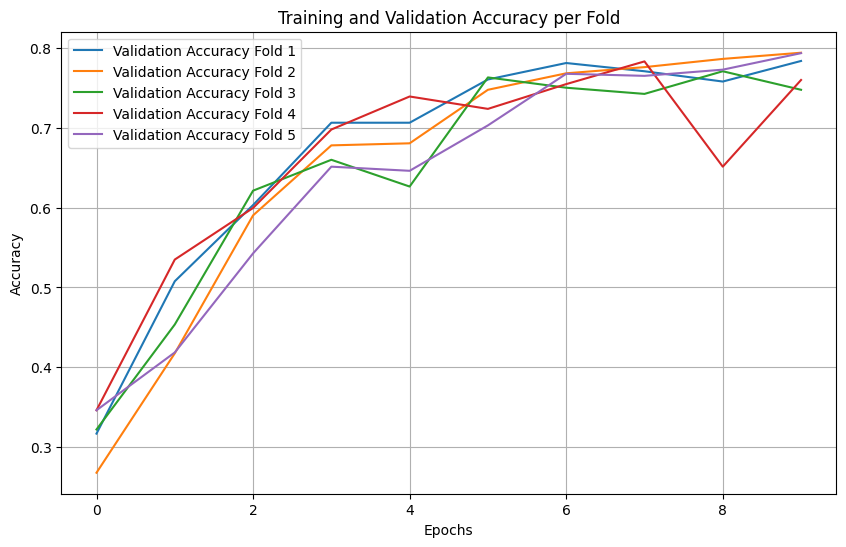

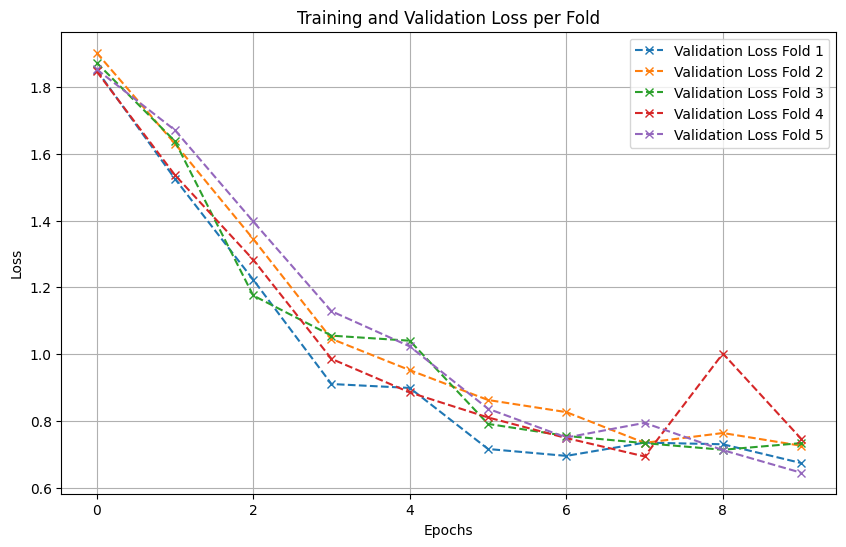

In [ ]:
k_fold_cross_validation(X_train, y_train, k=5, epochs=10, batch_size=50)

## Resnet

In [ ]:
def residual_module(input,channels):
  stride=1
  kernel_size=3
  x_shortcut = input
  x = BatchNormalization()(input)
  x = Activation('relu')(x)
  x = Conv1D(channels, (1))(x)
  x = Dropout(0.3)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(channels, kernel_size, padding='same', strides=stride)(x)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv1D(channels, kernel_size, padding='same', strides=stride)(x)
  output = Add()([x, x_shortcut])
  return(output)

In [ ]:
def resnet():
    """
    Creates a simple 1D Residual Network (ResNet) for classification tasks.
    This network stacks multiple residual blocks, followed by global average pooling and a dense output layer.

    Returns:
    Model: The complete ResNet model.
    """
    n_residual = 2  # Number of residual modules in the network
    print("Simple residual network with {} modules".format(n_residual))

    # Define the input layer with the shape
    inputs = Input(shape=(400, 20))

    # Pass the input through the residual blocks
    residual_i = inputs
    for _ in range(n_residual):
        residual_i = residual_module(residual_i, 20)

    # Apply global average pooling (1D) with a pooling size of 2 and stride of 1
    gavg_1 = AveragePooling1D((2), strides=(1))(residual_i)

    # Flatten the output to prepare it for the fully connected (Dense) layer
    flat_1 = Flatten()(gavg_1)

    # Dense output layer with 3 neurons (for 3 output classes) and softmax activation
    # Softmax is used for multi-class classification, providing probability distribution over the classes
    output = Dense(10, activation="softmax")(flat_1)

    # Define the model by specifying the inputs and outputs
    model = Model(inputs=inputs, outputs=output)

    return model

# Create the ResNet model
model = resnet()

# Print the summary of the model architecture
print(model.summary())

# Compile the model with Adam optimizer and categorical crossentropy loss (for multi-class classification)
# The 'accuracy' metric will be used to monitor the model's performance during training
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'], weighted_metrics=["accuracy"])

Simple residual network with 2 modules


Model: "functional_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_48            │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_422   │ (None, 400, 20)        │             80 │ input_layer_48[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_422            │ (None, 400, 20)        │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_470 (Conv1D)       │ (None, 400, 20)        │            420 │ activation_422[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_152 (Dropout)     │ (None, 400, 20)        │              0 │ conv1d_470[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_423   │ (None, 400, 20)        │             80 │ dropout_152[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_423            │ (None, 400, 20)        │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_471 (Conv1D)       │ (None, 400, 20)        │          1,220 │ activation_423[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_424   │ (None, 400, 20)        │             80 │ conv1d_471[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_424            │ (None, 400, 20)        │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_472 (Conv1D)       │ (None, 400, 20)        │          1,220 │ activation_424[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_145 (Add)             │ (None, 400, 20)        │              0 │ conv1d_472[0][0],      │
│                           │                        │                │ input_layer_48[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_425   │ (None, 400, 20)        │             80 │ add_145[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_425            │ (None, 400, 20)        │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_473 (Conv1D)  

 Total params: 86,010 (335.98 KB)

 Trainable params: 85,770 (335.04 KB)

 Non-trainable params: 240 (960.00 B)

None


In [ ]:
history_resnet = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=40)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.2944 - loss: 2.2789 - weighted_accuracy: 0.2944 - val_accuracy: 0.1572 - val_loss: 2.2407 - val_weighted_accuracy: 0.1572
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.6487 - loss: 1.0650 - weighted_accuracy: 0.6487 - val_accuracy: 0.1289 - val_loss: 2.2676 - val_weighted_accuracy: 0.1289
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.8239 - loss: 0.5925 - weighted_accuracy: 0.8239 - val_accuracy: 0.1443 - val_loss: 2.1735 - val_weighted_accuracy: 0.1443
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8814 - loss: 0.3890 - weighted_accuracy: 0.8814 - val_accuracy: 0.1392 - val_loss: 2.1951 - val_weighted_accuracy: 0.1392
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9378 - loss: 0.2319 - weighted_accuracy: 0.9378 - val_accuracy: 0.1392 - val_loss: 2.3120 - val_weighted_accuracy: 0.1392
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accura

In [ ]:
scores_train = model.evaluate(X_train, y_train)
scores = model.evaluate(X_test, y_test)
print("Neural network train accuracy: %.2f%%" % (scores_train[1]*100))
print("Neural network accuracy: %.2f%%" % (scores[1]*100))

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9885 - loss: 0.0681 - weighted_accuracy: 0.9885
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7287 - loss: 2.0191 - weighted_accuracy: 0.7287
Neural network train accuracy: 93.86%
Neural network accuracy: 71.75%


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


<Axes: >

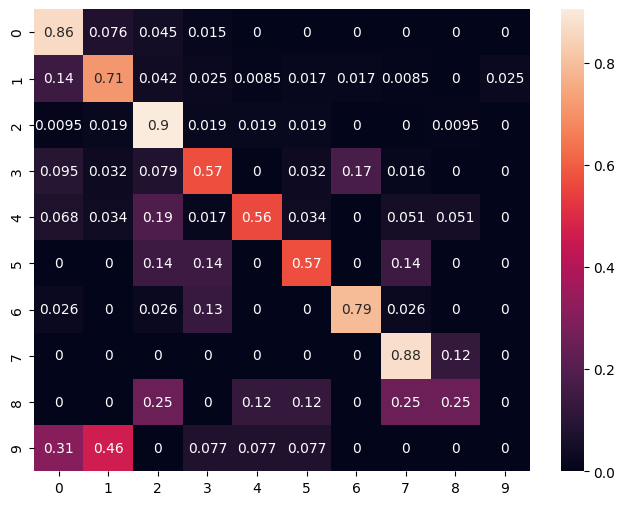

In [ ]:
y_pred_res = model.predict(X_test)
y_pred_classes_res = np.argmax(y_pred_res,axis = 1)

y_test_classes_res = np.argmax(y_test,axis = 1)
plt.figure(figsize=(8, 6))
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes_res, y_pred_classes_res, normalize="true"), annot=True)

In [ ]:
def k_fold_cross_validation(X, y, k=5, epochs=10, batch_size=100):
    kfold = KFold(n_splits=k, shuffle=True, random_state=3)
    accuracy_per_fold = []
    fold_no = 1

    # Pour stocker les historiques de chaque pli
    all_acc = []
    all_val_acc = []
    all_loss = []
    all_val_loss = []

    for train_index, val_index in kfold.split(X):
        # Créer le modèle pour chaque pli
        model = resnet()
        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'], weighted_metrics=["accuracy"])

        print(f'Entraînement du fold {fold_no}...')

        # Séparer les données d'entraînement et de validation
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Entraînement du modèle sur les données d'entraînement du pli
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size)

        # Sauvegarder les historiques pour chaque pli
        all_acc.append(history.history['accuracy'])
        all_val_acc.append(history.history['val_accuracy'])
        all_loss.append(history.history['loss'])
        all_val_loss.append(history.history['val_loss'])

        # Évaluer le modèle sur les données de validation du pli
        scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        print(f'Fold {fold_no} - Accuracy: {scores[1]*100:.2f}%')
        accuracy_per_fold.append(scores[1] * 100)

        fold_no += 1

    # Résultats
    print('\nScores de chaque fold:', accuracy_per_fold)
    print(f'Moyenne de l\'accuracy: {np.mean(accuracy_per_fold):.2f}%')
    print(f'Variance de l\'accuracy: {np.std(accuracy_per_fold):.2f}%')

    # Tracer les courbes d'accuracy et de loss pour tous les plis sur un seul graphique
    plt.figure(figsize=(10, 6))

    # Tracer accuracy pour tous les plis
    for i in range(k):
        plt.plot(all_val_acc[i], label=f'Validation Accuracy Fold {i+1}')

    # Ajouter les titres et les légendes
    plt.title('Training and Validation Accuracy per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Afficher le graphique
    plt.show()

    # Tracer les courbes de loss pour tous les plis sur un seul graphique
    plt.figure(figsize=(10, 6))

    # Tracer loss pour tous les plis
    for i in range(k):
        plt.plot(all_val_loss[i], label=f'Validation Loss Fold {i+1}', linestyle='--', marker='x')

    # Ajouter les titres et les légendes
    plt.title('Training and Validation Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Afficher le graphique
    plt.show()

Simple residual network with 2 modules
Entraînement du fold 1...
Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.2287 - loss: 2.4974 - weighted_accuracy: 0.2287 - val_accuracy: 0.2655 - val_loss: 2.1941 - val_weighted_accuracy: 0.2655
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.6051 - loss: 1.2072 - weighted_accuracy: 0.6051 - val_accuracy: 0.2526 - val_loss: 2.1371 - val_weighted_accuracy: 0.2526
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.7277 - loss: 0.8323 - weighted_accuracy: 0.7277 - val_accuracy: 0.2861 - val_loss: 2.1420 - val_weighted_accuracy: 0.2861
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.8260 - loss: 0.5386 - weighted_accuracy: 0.8260 - val_accuracy: 0.2809 - val_loss: 2.0385 - val_weighted_accuracy: 0.2809
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.8934 - loss: 0.3395 - weighted_accuracy: 0.8934 - val_accuracy: 0.2526 - val_loss: 2.1399 - val_weighted_accuracy: 0.2

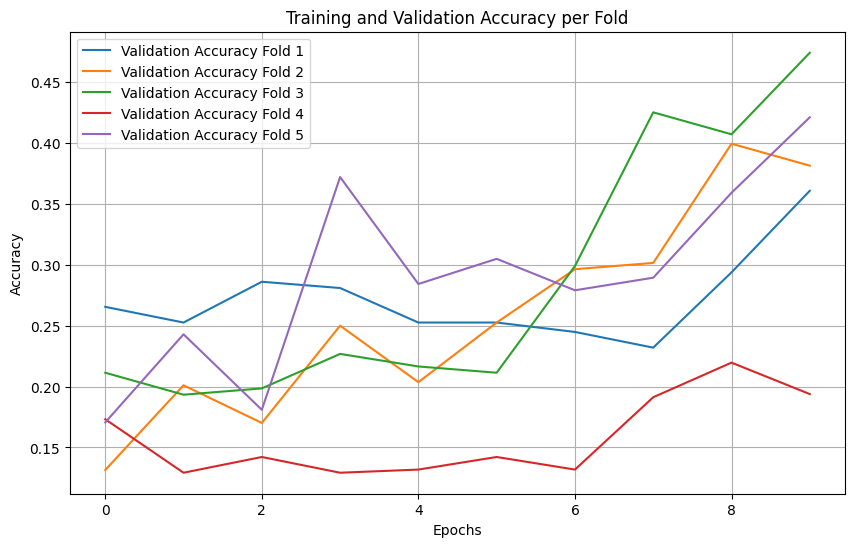

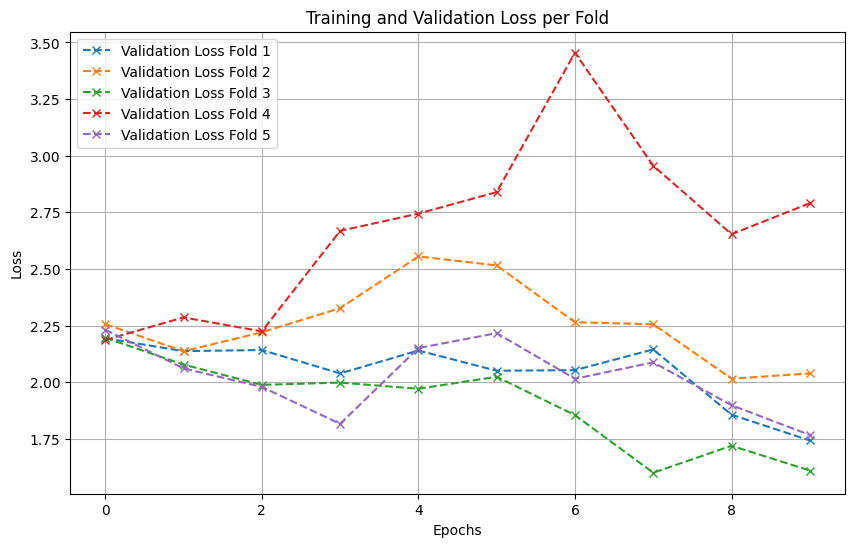

In [ ]:
k_fold_cross_validation(X_train, y_train, k=5, epochs=10, batch_size=50)